# Test DEMV on Obesity Dataset

- Positive label: `Normal_Weight`
- Protected group: `Gender: 1, Age: 1`

In [154]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, GridSearch

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [155]:
def prepare_data():
  data = pd.read_csv('data2/obesity.csv')
  data.drop(['NObeyesdad', 'weight_cat', 'yhat', 'a'], axis=1, inplace=True)
  le = LabelEncoder()
  data['Gender'] = le.fit_transform(data['Gender'].values)
  data['y'].replace({
    'Normal_Weight': 0,
    'Overweight_Level_I': 1,
    'Overweight_Level_II': 2,
    'Obesity_Type_I': 3,
    'Insufficient_Weight': 4
  }, inplace=True)
  data['family_history_with_overweight']=le.fit_transform(data['family_history_with_overweight'].values)
  data['FAVC'] = le.fit_transform(data['FAVC'].values)
  data['CAEC'] = le.fit_transform(data['CAEC'].values)
  data['SMOKE'] = le.fit_transform(data['SMOKE'].values)
  data['SCC'] = le.fit_transform(data['SCC'].values)
  data['CALC'] = le.fit_transform(data['CALC'].values)
  data['MTRANS'] = le.fit_transform(data['MTRANS'].values)
  data.loc[data['Age'] < 22 , 'Age'] = 0
  data.loc[data['Age'] >= 22, 'Age'] = 1
  return data

In [156]:
data = prepare_data()

In [157]:
data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,y
0,0,0.0,1.620000,64.000000,1,0,2.000000,3.000000,2,0,2.000000,0,0.000000,1.000000,3,3,0
1,0,0.0,1.520000,56.000000,1,0,3.000000,3.000000,2,1,3.000000,1,3.000000,0.000000,2,3,0
2,1,1.0,1.800000,77.000000,1,0,2.000000,3.000000,2,0,2.000000,0,2.000000,1.000000,1,3,0
3,1,1.0,1.800000,87.000000,0,0,3.000000,3.000000,2,0,2.000000,0,2.000000,0.000000,1,4,1
4,1,1.0,1.780000,89.800000,0,0,2.000000,1.000000,2,0,2.000000,0,0.000000,0.000000,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,1,0.0,1.705304,99.873716,1,1,2.000000,1.293342,2,0,2.000000,0,0.000000,1.917679,3,3,3
1486,0,0.0,1.612910,82.193405,1,1,1.261288,2.930044,2,0,1.166655,0,0.133398,0.951740,3,3,3
1487,0,0.0,1.605469,82.039000,1,1,2.765330,3.000000,2,0,1.048584,0,0.192559,0.720411,3,3,3
1488,1,0.0,1.804160,104.406820,1,1,2.000000,3.000000,2,0,3.000000,0,2.240500,0.000000,3,3,3


<AxesSubplot:>

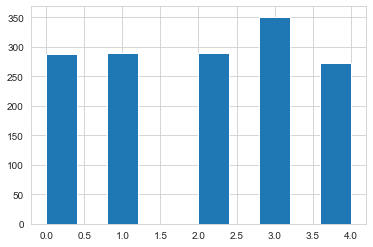

In [158]:
data['y'].hist()

In [159]:
data = data.loc[data['y'] != 4]

In [160]:
label = 'y'
positive_label = 0
protected_group = {'Gender': 1, 'Age': 1}
sensitive_vars = ['Gender', 'Age']

In [161]:
pipeline = Pipeline(steps=[
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased classifier

In [162]:
model, metrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_vars, positive_label)
print_metrics(metrics)

Statistical parity:  -0.103  +-  0.1
Disparate impact:  0.564  +-  0.267
Zero one loss:  0.124  +-  0.042
F1 score:  0.929  +-  0.021
Accuracy score:  0.929  +-  0.021


## DEMV classifier

In [18]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [19]:
model, demv_metrics = cross_val(deepcopy(pipeline), demv_data, label, protected_group, sensitive_features=sensitive_vars, debiaser=demv, positive_label=positive_label)
print_metrics(demv_metrics)

Statistical parity:  -0.039  +-  0.064
Disparate impact:  0.639  +-  0.128
Zero one loss:  0.102  +-  0.031
F1 score:  0.905  +-  0.021
Accuracy score:  0.906  +-  0.021


## DEMV Evaluation

In [23]:
iters = demv.get_iters()

In [24]:
iters

52

In [25]:
metrics = eval_demv(10, iters, data.copy(), pipeline, label, protected_group, sensitive_vars, positive_label=positive_label)

##  Blackbox Postprocessing

In [163]:
sensitive_features = ['combined']
unpriv_group = {'combined': 1}

In [164]:
data.loc[:,"combined"] = 0
data.loc[(data['Age'] == 1) & (data["Gender"] == 1),"combined"] = 1

In [165]:
#Now pred contains the actual values on column "y_true" and predicted values on column "contr_use"

pred.loc[:,"combined"] = 0
pred.loc[(pred['Age'] == 1) & (pred["Gender"] == 1),"combined"] = 1

In [166]:
y_pred = pred[label].values
y_true = pred['y_true'].values

In [167]:
import tools
stats = tools.clf_metrics(y_true, y_pred)
stats

,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,286.0,21.0,890.0,21.0,0.9286,0.9774,0.9294,0.9771,0.906,0.9288,0.9062,0.0344,0.0,0.0,307.0,307.0,-0.0,0.0


In [168]:
blackboxmetrics = blackboxCVmetrics( data, label, y_true, unpriv_group, pred )


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.0000  0.9167
1  0.0323  0.8333
2  0.0462  1.0000
3  0.0000  1.0000

1
      fpr     tpr
0  0.0270  0.8000
1  0.0278  0.6667
2  0.0741  1.0000
3  0.0000  0.9375


And loss is 0.0738


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.0000  0.9524
1  0.0185  0.8235
2  0.0536  1.0000
3  0.0000  1.0000

1
      fpr  tpr
0  0.0303  0.8
1  0.0303  0.6
2  0.0435  1.0
3  0.0000  1.0


And loss is 0.0642

[7.99999999e-01 4.95572640e-02 2.86394686e-09 1.50442734e-01]
[0.04884042 0.6        0.1202971  0.23086248]
[0.03782019 0.03294067 0.68168358 0.24755556]
[6.53119886e-03 5.64172431e-03 1.76690695e-09 9.87827075e-01]
[7.99999999e-01 2.00000000e-01 3.72093948e-10 2.32155139e-10]
[0.2        0.6        0.13633672 0.06366328]
[2.08441843e-10 6.75859533e-10 6.81683581e-01 3.18316418e-01]
[2.17622741e-10 2.48430152e-10 1.21729245e-02 9.87827075e-01]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.0000  0.9048
1  0.0377  0.

ValueError: could not broadcast input array from shape (4,3) into shape (4,4)

##  Plot

In [ ]:
df = prepareplots(metrics, 'obesity')

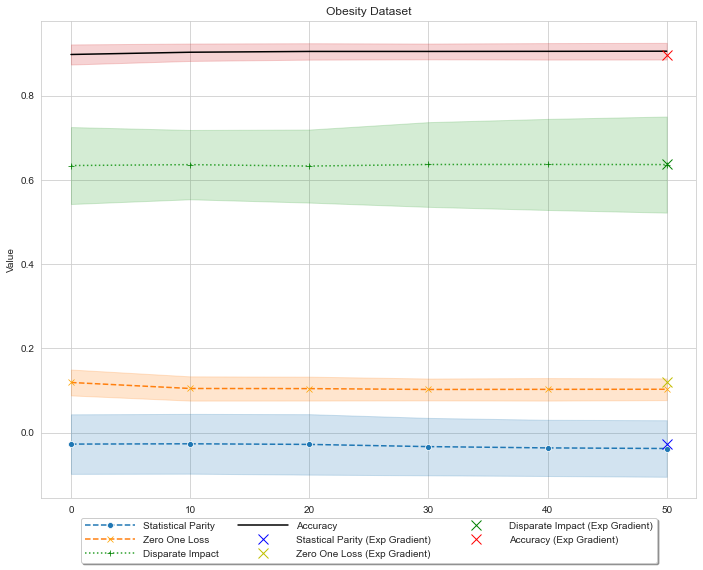

In [ ]:
points = preparepoints(blackboxmetrics, 50)

plot_metrics_curves(df, points, 'Obesity Dataset')

In [ ]:
unprivpergentage(data, protected_group, 52)

Dataset size: 1490
Unprivileged group size: 361
Percentage of unprivileged group: 24.22818791946309
Number of iterations: 52
